In [11]:
import numpy as np
from models import DLDSwithControl, DeepDLDS, SimpleNN
from datasets import CdLDSDataGenerator
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import util

In [33]:
K = 2
generator = DLDSwithControl(CdLDSDataGenerator(K=K, D_control=0, fix_point_change=True, eigenvalue_radius=0.999))

time_points = 1000

# generate toy data
X = generator.datasets.generate_data(time_points, sigma=0.00)
if K == 1:
    states = torch.ones(time_points, 1).squeeze()
else:
    states = generator.datasets.z_#[1:]

# z-score normalization
# X = (X - X.mean(axis=0)) / X.std(axis=0)
np.save('data.npy', X)

X1 = torch.tensor(X[:, :-1], dtype=torch.float32)
X2 = torch.tensor(X[:, 1:], dtype=torch.float32)

In [34]:
# calculate the next time steps
X_test = []
for t in range(1, time_points):
    next_state = generator.datasets.A @ X[:, t-1]
    X_test.append(next_state)
px.line(X2.T - np.array(X_test).reshape(-1,4)) #change unit

ValueError: operands could not be broadcast together with shapes (999,4) (1998,4) 

In [35]:
# save the As of the model
np.save('As.npy', np.array(generator.datasets.A))

np.save('states.npy', generator.datasets.z_)

In [36]:
st = generator.datasets.z_
# one hot encoded states
one_hot_states = np.zeros((K,len(st)))
one_hot_states[st,np.arange(len(st))] = 1


In [37]:
one_hot_states

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [38]:
num_subdyn = 2
input_size = X1.shape[0]
output_size = X2.shape[0]

simple_model = DeepDLDS(input_size, output_size, num_subdyn, X1.shape[1])
model = torch.load('models/model.pth', weights_only=False)
simple_model.load_state_dict(model)

X2_hat = util.single_step(X1.T, simple_model) # single step reconstruction
X2_hat_multi = util.multi_step(X1.T, simple_model) # multi step reconstruction

In [39]:
util.plotting(X2.T, title='Ground Truth', plot_states=True, states=states)
util.plotting(torch.stack(X2_hat).squeeze(), title='Single-step reconstruction', plot_states=True, states=states)
util.plotting(torch.stack(X2_hat_multi[1:]).squeeze(), plot_states=True, states=states, title='Multi-step reconstruction')

coefficients = np.array([c.detach().numpy() for c in simple_model.coeffs])

util.plotting(coefficients.T, plot_states=True, states=states, title='Coefficients of the model')

In [19]:
# plot the residuals
residuals1 = X2.T - torch.stack(X2_hat).squeeze()

util.plotting(residuals1, title='Residuals of the single-step reconstruction', plot_states=True, states=states)

# plot the residuals of multi-step
residuals2 = X2.T - torch.stack(X2_hat_multi[1:]).squeeze()

util.plotting(residuals2, title='Residuals of the multi-step reconstruction', plot_states=True, states=states)

In [11]:
simple_model.F

ParameterList(
    (0): Object of type: BoundedNormLinear
  (0): BoundedNormLinear(
    (linear): Linear(in_features=4, out_features=4, bias=False)
  )
)

In [12]:
generator.datasets.A

[array([[ 0.96750433, -0.09002626,  0.05836665, -0.22455507],
        [ 0.09479548,  0.97707187,  0.17461164,  0.06209795],
        [-0.0455762 , -0.1777081 ,  0.97363908,  0.12794759],
        [ 0.22555044, -0.06038765, -0.12701202,  0.96298976]])]

In [13]:
simple_model.F[0].effective_W()

tensor([[ 0.9734,  0.0958, -0.0460,  0.2271],
        [-0.0905,  0.9822, -0.1787, -0.0604],
        [ 0.0587,  0.1754,  0.9800, -0.1277],
        [-0.2261,  0.0600,  0.1276,  0.9688]], grad_fn=<PermuteBackward0>)

In [14]:
simple_model.F[0].weight

Parameter containing:
tensor([[ 0.9734, -0.0905,  0.0587, -0.2261],
        [ 0.0958,  0.9822,  0.1754,  0.0600],
        [-0.0460, -0.1787,  0.9800,  0.1276],
        [ 0.2271, -0.0604, -0.1277,  0.9688]], requires_grad=True)

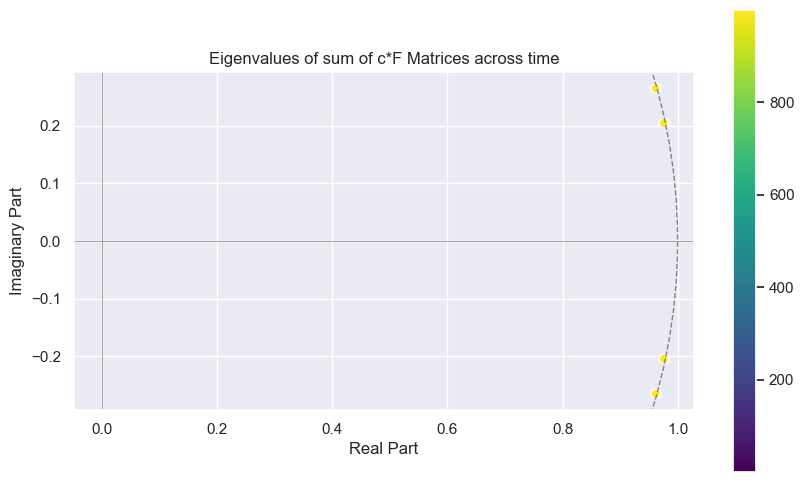

In [15]:
#%%script true
import numpy.linalg as linalg
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()


plt.figure(figsize=(10, 6))

colors = {'1': 'red', '2': 'blue', '3': 'green', '4': 'purple'}  

data = []

for t in range(X2.shape[1]):
    f_sum = np.sum([simple_model.coeffs[idx].detach().numpy()[t]*f_i.weight.detach().numpy() for idx, f_i in enumerate(simple_model.F)], axis=0)
    eigenvalue = linalg.eig(f_sum)[0]
    df = pd.DataFrame({'real': np.real(eigenvalue), 'imag': np.imag(eigenvalue)})
    data.append(df)
              
df = pd.concat(data, keys=[str(i+1) for i in range(X2.shape[1])])

ax = sns.scatterplot(data=df, x='real', y='imag', alpha=1, hue=df.index.get_level_values(0), palette='viridis', marker='o', legend=False)

# Add a colorbar
norm = plt.Normalize(1, 999)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Needed to trick colorbar into working with ScalarMappable

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=norm),
    ax=plt.gca()
)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of sum of c*F Matrices across time')

# Add a unit circle
unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

# Set equal scaling to ensure the unit circle is round
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()
